# 1. 250-dimensional Multivariate Normal (MVN)

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import wishart
from bml.samplers import nuts, hmc
from bml import metrics

In [2]:
d = 250 # dimension
A = wishart.rvs(df=d, scale=np.eye(d)) # precision matrix

In [3]:
def log_p(theta):
    return -0.5 * np.dot(theta, np.dot(A, theta))

def grad_log_p(theta):
    return -np.dot(A, theta)

In [4]:
theta0 = np.zeros(d) # Zero-mean starting point
M = 2000             # Total iterations
M_adapt = 1000       # Warmup/adaptation iterations
delta = 0.65         # Target acceptance rate

In [9]:
results = {}

for sampler_name, SamplerClass in [("Dual Averaging NUTS", nuts.DualAveragingNUTS), ("Efficient NUTS", nuts.EfficientNUTS), ("Dual Averaging HMC", hmc.DualAveragingHMC)]:
    print(f"Starting {sampler_name} sampling for {d}-dimensional MVN...")
    if sampler_name == "Efficient NUTS":
        sampler = SamplerClass(epsilon=0.01, L=log_p, grad=grad_log_p)
        samples = sampler.sample(theta0, M=M)
    elif sampler_name == "Dual Averaging HMC":
        sampler = SamplerClass(L=log_p, grad=grad_log_p)
        samples = sampler.sample(theta0, delta=delta, lam=0.5, M=M, M_adapt=M_adapt)
    else:
        sampler = SamplerClass(L=log_p, grad=grad_log_p)
        samples = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)

    print(f"Finished sampling with {sampler_name}. Output shape: {samples.shape}")
    
    valid_samples = samples[M_adapt:]
    min_ess = metrics.evaluate_mvn_efficiency(valid_samples, A)
    results[sampler_name] = min_ess
    print(f"Worst-case ESS across all dimensions for {sampler_name}: {min_ess:.4f}\n")

Starting Dual Averaging NUTS sampling for 250-dimensional MVN...
Finished sampling with Dual Averaging NUTS. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Dual Averaging NUTS: 30.8842

Starting Efficient NUTS sampling for 250-dimensional MVN...
Finished sampling with Efficient NUTS. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Efficient NUTS: 92.3097

Starting Dual Averaging HMC sampling for 250-dimensional MVN...
Finished sampling with Dual Averaging HMC. Output shape: (2001, 250)
Worst-case ESS across all dimensions for Dual Averaging HMC: 0.5419



In [11]:
class GradCounter:
    """Wrapper to count how many times the gradient function is called."""
    def __init__(self, A):
        self.A = A
        self.count = 0
        
    def grad(self, theta):
        self.count += 1
        return -np.dot(self.A, theta)
        
    def log_p(self, theta):
        return -0.5 * np.dot(theta, np.dot(self.A, theta))

In [12]:
deltas = np.linspace(0.25, 0.95, 15)
results_delta = []

for delta in deltas:
    print(f"Sampling for Delta={delta:.2f}...")

    model = GradCounter(A)
    sampler = nuts.DualAveragingNUTS(L=model.log_p, grad=model.grad)

    theta0 = np.zeros(d)

    samples = sampler.sample(theta0, delta=delta, M=M, M_adapt=M_adapt)
    valid_samples = samples[M_adapt:]
    min_ess = metrics.evaluate_mvn_efficiency(valid_samples, A)
    total_gradients = model.count
    ess_per_gradient = min_ess / total_gradients
    results_delta.append((delta, min_ess, total_gradients, ess_per_gradient))
    print(f"Delta: {delta:.2f}, Worst-case ESS: {min_ess:.4f}, Total Gradients: {total_gradients}, ESS/Gradient: {ess_per_gradient:.6f}\n")

results_df = pd.DataFrame(results_delta, columns=["Delta", "Worst-case ESS", "Total Gradients", "ESS per Gradient"])
results_df.to_csv("../results/MVN/DANUTS_delta.csv", index=False)

Sampling for Delta=0.25...
Delta: 0.25, Worst-case ESS: 49.1500, Total Gradients: 1601618, ESS/Gradient: 0.000031

Sampling for Delta=0.30...
Delta: 0.30, Worst-case ESS: 68.6253, Total Gradients: 1731198, ESS/Gradient: 0.000040

Sampling for Delta=0.35...
Delta: 0.35, Worst-case ESS: 83.2726, Total Gradients: 1855376, ESS/Gradient: 0.000045

Sampling for Delta=0.40...
Delta: 0.40, Worst-case ESS: 49.9020, Total Gradients: 1853188, ESS/Gradient: 0.000027

Sampling for Delta=0.45...
Delta: 0.45, Worst-case ESS: 63.8776, Total Gradients: 1962724, ESS/Gradient: 0.000033

Sampling for Delta=0.50...
Delta: 0.50, Worst-case ESS: 44.4266, Total Gradients: 2106394, ESS/Gradient: 0.000021

Sampling for Delta=0.55...
Delta: 0.55, Worst-case ESS: 50.3244, Total Gradients: 2128228, ESS/Gradient: 0.000024

Sampling for Delta=0.60...
Delta: 0.60, Worst-case ESS: 20.4116, Total Gradients: 2273504, ESS/Gradient: 0.000009

Sampling for Delta=0.65...
Delta: 0.65, Worst-case ESS: 45.1736, Total Gradients

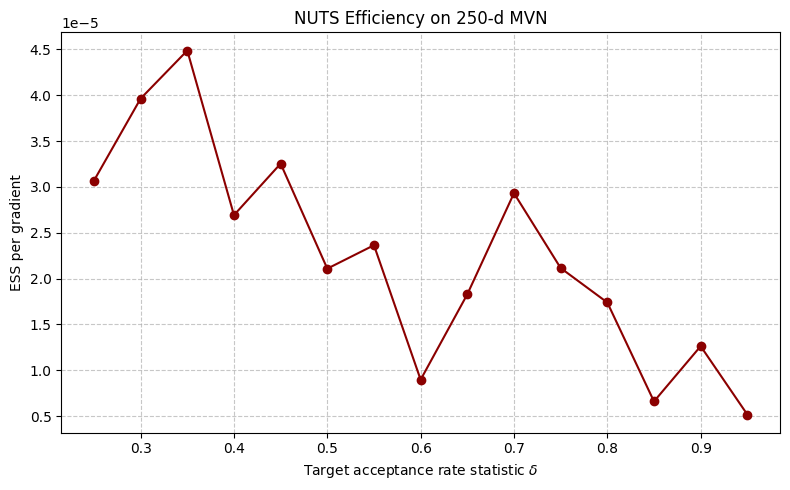

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Delta"], results_df["ESS per Gradient"], marker='o', linestyle='-', color='darkred')
plt.xlabel('Target acceptance rate statistic $\\delta$')
plt.ylabel('ESS per gradient')
plt.title(f'NUTS Efficiency on {d}-d MVN')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"../results/MVN/{d}d_efficiency_plot.png")